In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import pandas as pd
import numpy as np
import os
import sys
import sqlalchemy as sa

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
    

load_dotenv()

True

In [3]:
conn_string = 'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/cosmetic'.format(
    db_user=os.getenv('DB_USER'),
    db_password=os.getenv('DB_PASSWORD'),
    db_host=os.getenv('DB_HOST'),
    db_port=os.getenv('DB_PORT'),
)
engine = sa.create_engine(conn_string)

In [4]:
from collections import defaultdict
from sqlalchemy import orm
import datetime

from schemas.product import Product
from schemas.data_by_date import DataByDate
from training.utils import date_range, data_descale, preprocess_c

prev_days = int(os.getenv('PREV_DAYS'))

def predict_from(start: datetime.date, future = 30):
    with orm.Session(engine) as session, session.begin():
        products = dict[tuple[int, int], Product]()
        for row in session.scalars(sa.select(Product)).all():
            products[(row.product_id, row.category_id)] = row
        
        memorized = defaultdict(lambda: defaultdict(lambda: { 'view': 0, 'cart': 0, 'remove_from_cart': 0, 'purchase': 0 }))

        d = start - datetime.timedelta(days=prev_days)
        for i in range(prev_days):
            for row in session.scalars(sa.select(DataByDate).where(DataByDate.date == d).order_by(DataByDate.rank.asc())):
                key = (row.product_id, row.category_id)
                memorized[d][key] = {
                    'view': row.view,
                    'cart': row.cart,
                    'remove_from_cart': row.remove_from_cart,
                    'purchase': row.purchase,
                }

            d += datetime.timedelta(days=1)
        
        all_result_df = list[pd.DataFrame]()
        for _ in range(future):
            records = list[dict]()

            rows = list[dict]()
            categories = defaultdict(lambda: list[dict]())
            for row in session.scalars(sa.select(DataByDate).where(DataByDate.date == d).order_by(DataByDate.rank.asc())):
                key = (row.product_id, row.category_id)
                record = {
                    'product_id': row.product_id,
                    'category_id': row.category_id,
                    'view': row.view,
                    'cart': row.cart,
                    'remove_from_cart': row.remove_from_cart,
                    'purchase': row.purchase,
                    'rank': row.rank,
                    'rank_in_category': row.rank_in_category,
                    'days_on_shelf': (d - products[key].release_date).days,
                    'price': row.max_price,
                }

                rows.append(record)
                categories[row.category_id].append(record)

            
            def key_func(record: dict):
                key = (record['product_id'], record['category_id'])
                prev_sales = sum(memorized[p][key]['purchase'] for p in date_range(d - datetime.timedelta(days=prev_days), d, datetime.timedelta(days=1)))
                return -prev_sales, record['days_on_shelf'], record['price']
            
            for category in categories.values():
                category.sort(key=key_func)
                for index, record in enumerate(category):
                    record['rank_in_category'] = index + 1

            rows.sort(key=key_func)      
            
            for index, record in enumerate(rows):
                record['rank'] = index + 1

                key = (record['product_id'], record['category_id'])

                for i in range(1, prev_days + 1):
                    prev_d = d - datetime.timedelta(days=i)
                    record[f'view_prev{i}'] = memorized[prev_d][key]['view']
                    record[f'cart_prev{i}'] = memorized[prev_d][key]['cart']
                    record[f'remove_from_cart_prev{i}'] = memorized[prev_d][key]['remove_from_cart']
                    record[f'purchase_prev{i}'] = memorized[prev_d][key]['purchase']

                if (d - products[key].release_date).days >= 7:
                    records.append(record)
                else:
                    memorized[d][key] = {
                        'view': record['view'],
                        'cart': record['cart'],
                        'remove_from_cart': record['remove_from_cart'],
                        'purchase': record['purchase'],
                    }
            
            del memorized[d - datetime.timedelta(days=prev_days)]

            df = pd.DataFrame.from_records(records)
            result_df = df.loc[:,[
                'product_id', 
                'category_id', 
                'rank',
                'rank_in_category',
                'view', 
                'cart', 
                'remove_from_cart', 
                'purchase', 
            ]]
            df = df.drop(columns=['product_id', 'category_id'])
            X1, X2, y = preprocess_c(df)
            result_df['predicted_view'] = data_descale(model_view.predict([X1, X2])[:, 0], 'view')
            result_df['predicted_cart'] = data_descale(model_cart.predict([X1, X2])[:, 0], 'cart')
            result_df['predicted_remove_from_cart'] = data_descale(model_remove_from_cart.predict([X1, X2])[:, 0], 'remove_from_cart')
            result_df['predicted_purchase'] = data_descale(model_purchase.predict([X1, X2])[:, 0], 'purchase')
            result_df['date'] = d
            
            for result in result_df.to_dict('records'):
                key = (result['product_id'], result['category_id'])
                memorized[d][key] = {
                    'view': result['predicted_view'],
                    'cart': result['predicted_cart'],
                    'remove_from_cart': result['predicted_remove_from_cart'],
                    'purchase': result['predicted_purchase'],
                }

            all_result_df.append(result_df)

            d += datetime.timedelta(days=1)
    
    name = d.strftime('%Y-%m-%d')
    pd.concat(all_result_df).to_csv(f'../.data/predict/d-{name}.csv')        

    return all_result_df     

In [6]:
from keras.metrics import RootMeanSquaredError
from keras.models import Model, load_model
import csv

from training.utils import date_range

models: dict[str, Model] = {
    'view': load_model('../model/c-view.keras'),
    'cart': load_model('../model/c-cart.keras'),
    'remove_from_cart': load_model('../model/c-remove_from_cart.keras'),
    'purchase': load_model('../model/c-purchase.keras'),
}

statistics = list[dict]()
for d in date_range(datetime.date(2019, 11, 1), datetime.date(2020, 3 , 1), datetime.timedelta(days=1)):
    ans = { 'date': d }
    df = pd.read_csv(f'../datasets/d{d.strftime("%Y-%m-%d")}.csv')
    X1, X2, y = preprocess_c(df)
    for feature in models.keys():
        df[f'predicted_{feature}'] = data_descale(models[feature].predict([X1, X2])[:, 0], feature)
        metrics = RootMeanSquaredError()
        metrics.update_state(df[feature], df[f'predicted_{feature}'])
        ans[feature] = metrics.result().numpy()
    statistics.append(ans)

with open('../.data/statistics/rmse.csv', 'w', newline='') as output_file:
    writer = csv.DictWriter(output_file, statistics[0].keys())
    writer.writeheader()
    writer.writerows(statistics)
    statistics.clear()


567/567 [==============================] - 1s 1ms/step


<Axes: title={'center': 'RMSE through days'}, xlabel='date'>

<Figure size 1200x600 with 0 Axes>

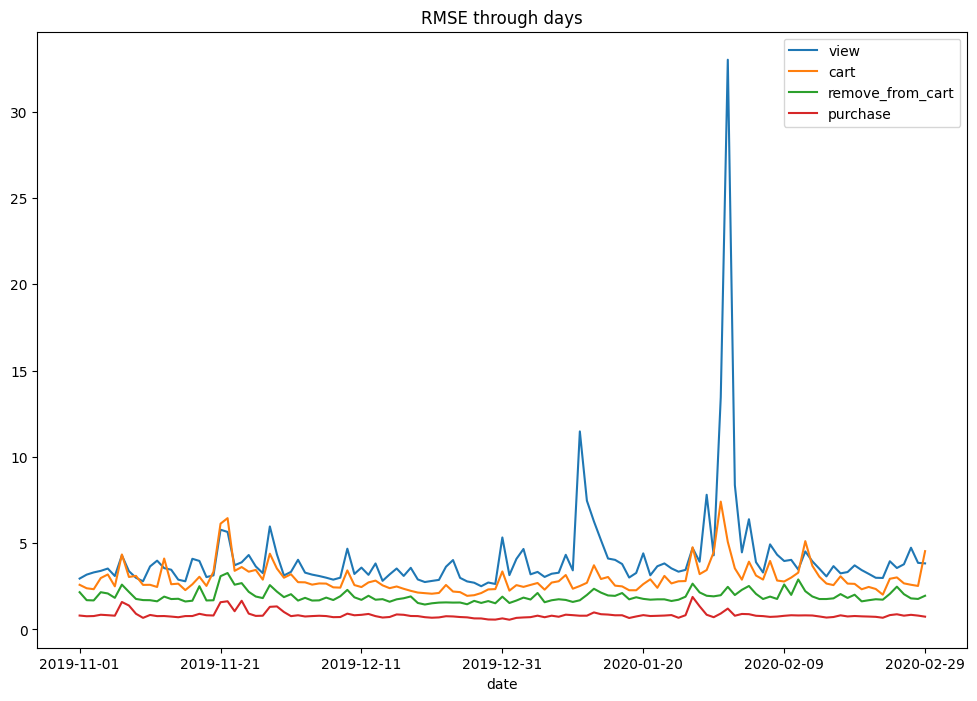

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df = pd.read_csv('../.data/statistics/rmse.csv')
df.index = df['date']
df.plot(figsize=(12, 8), title="RMSE through days")